### PyTorch Three Levels of Abstraction

- **Tensor**: Imperative ndarray but runs on GPU
- **Variable**: Node in a computational graph, stores data and gradient
- ** Module**: A neural network layer; may store state or learnable weights

To run torch tensor define type as torch.cuda.FloatTensor

- **x.data**: is a Tensor
- **x.grad**: is a Variable fo gradients (same shape of x.data)
- **x.grad.data**: is Tensor of gradients

In [1]:
import torch
from torch.autograd import Variable


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### BASIC PYTORCH

In [3]:
dtype = torch.FloatTensor

In [29]:
N, D_in, H, D_out = 64, 1000, 100, 10
x = Variable(torch.randn(N, D_in).type(dtype), requires_grad=False)
y = Variable(torch.randn(N, D_out).type(dtype), requires_grad=False)
w1 = Variable(torch.randn(D_in, H).type(dtype),  requires_grad=True)
w2 = Variable(torch.randn(H, D_out).type(dtype),  requires_grad=True)

In [30]:
lr = 1e-6

In [31]:
loss_vals = []
for t in range(500):
    h = x.mm(w1)
    h_relu = h.clamp(min=0) #relu
    y_pred = h_relu.mm(w2)
    loss = (y - y_pred).pow(2).sum() # SSE
    loss_vals.append(loss)
    #zero the gradients before new update
    if t != 0:
        w1.grad.data.zero_()
        w2.grad.data.zero_()
    loss.backward()
    
    w1.data -= lr*w1.grad.data
    w2.data -= -lr*w2.grad.data

In [32]:
loss_data = [l.data.numpy()[0] for l in loss_vals]

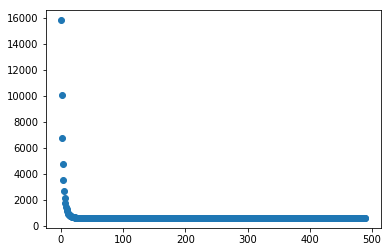

In [49]:
plt.scatter(np.arange(len(loss_data[10:])),np.array(loss_data[10:]))

### NN PACKAGE

In [23]:
N, D_in, H, D_out = 64, 1000, 100, 10
x = Variable(torch.randn(N, D_in).type(dtype), requires_grad=False)
y = Variable(torch.randn(N, D_out).type(dtype), requires_grad=False)

In [24]:
model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out))
loss_func = torch.nn.MSELoss(size_average=False)

In [25]:
lr = 1e-4
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr)

In [26]:
loss_vals = []
for t in range(500):
    y_pred = model(x)
    loss = loss_func(y_pred, y)
    loss_vals.append(loss.data.numpy()[0])
    model.zero_grad()
    
    #compute grads and update weights
    loss.backward()
    optimizer.step()

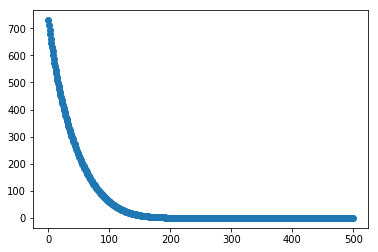

In [27]:
plt.scatter(np.arange(len(loss_vals)),np.array(loss_vals))

### DEFININIG OWN NN MODULES CLASS

In [35]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.Linear1 = torch.nn.Linear(D_in, H)
        self.Linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu = self.Linear1(x).clamp(min=0)
        y_pred = self.Linear2(h_relu)
        return y_pred

# specify arch of 2layer NN
N, D_in, H, D_out = 64, 1000, 100, 10

# create random data
x = Variable(torch.randn(N, D_in), requires_grad=False)
y = Variable(torch.randn(N, D_out), requires_grad=False)

# init model
model = TwoLayerNet(D_in, H, D_out)

criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [36]:
loss_vals = []
for t in range(500):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss_vals.append(loss.data.numpy()[0])
    
    #zero the gradients calculate new grads and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

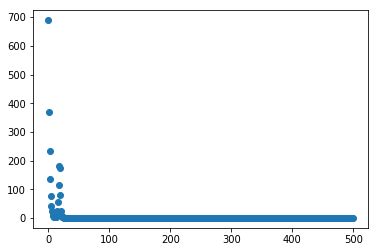

In [37]:
# we can see the sparsity of SGD optimizer
plt.scatter(np.arange(len(loss_vals)),np.array(loss_vals))

### TENSORFLOW (STATIC CG) VS PYTORCH (DYNAMIC CG)

**Tensorflow**
- With static graphs, framework can optimize the graph for you before it runs.
- Static grap can be serialized write and read on disk.
- TensorFlow Fold for dynamic batching

**PyTorch**
- Dynamic, code is necessary to re-use the model.
- Dynamic is cleaner code.
- Conditional (Control FLow) can be used 
- Loops are easier, recurrent relationships (RNNs) - Modular Networks, Your creative cool ideas
- Visdom for visualization